In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.metrics import f1_score, log_loss, roc_auc_score, recall_score, accuracy_score, precision_score

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Stroke data/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [ ]:
DT_bmi_pipe = Pipeline(steps=[('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))])
X_BMI = df[['age','gender','bmi']].copy()
X_BMI.gender = X_BMI.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X_BMI[X_BMI.bmi.isna()]
X_BMI = X_BMI[~X_BMI.bmi.isna()]
Y_BMI = X_BMI.pop('bmi')
DT_bmi_pipe.fit(X_BMI,Y_BMI)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.879487,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [ ]:
df.drop(df[df['gender'] == "Other"].index, inplace = True)
df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [ ]:
df = df.loc[:, ['gender',	'age',	'hypertension',	'heart_disease', 'Residence_type',	'avg_glucose_level',	'bmi',	'smoking_status',	'stroke']]
df.head()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Rural,202.21,29.879487,never smoked,1
2,Male,80.0,0,1,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Rural,174.12,24.000000,never smoked,1


In [ ]:
X = df.drop("stroke", axis= "columns")
y = df.stroke

In [ ]:
from sklearn.preprocessing import LabelEncoder

num_cols = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_cols = X.select_dtypes(include = ['object']).columns.to_list()

In [ ]:
def label_encoder(df):
    for i in cat_cols:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    return df

In [ ]:
sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])

# Label encoding
X = label_encoder(X)

X.head()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,1.051242,-0.328637,4.184599,1,2.706450,0.993405,1
1,0,0.785889,-0.328637,-0.238972,0,2.121652,0.124145,2
2,1,1.626174,-0.328637,4.184599,0,-0.004867,0.463093,2
3,0,0.255182,-0.328637,-0.238972,1,1.437473,0.708847,3
4,0,1.581949,3.042866,-0.238972,0,1.501297,-0.636333,2


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
cv = 10
X_train, X_test, y_train, y_test = train_test_split( X.values, y.values, test_size=0.3, random_state=0)
print('Train set:', X_train.shape,  y_train.shape)
print('Test set:', X_test.shape,  y_test.shape)

oversample = SMOTE()
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)
print("After SMOTE :", X_train_balanced.shape, y_train_balanced.shape)

Train set: (3576, 8) (3576,)
Test set: (1533, 8) (1533,)
After SMOTE : (6806, 8) (6806,)


In [ ]:
results = pd.DataFrame(columns = ['LR', 'LGBM', 'RF', 'XGB', 'ADB', 'DT'], index = range(5))

In [ ]:
results_cv = pd.DataFrame(columns = ['LR', 'LGBM', 'RF', 'XGB', 'ADB', 'DT'], index = range(5))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100] 
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
log_param_grid = {'penalty': penalty, 
                  'C': C, 'solver': solver}

logreg = LogisticRegression()

grid = GridSearchCV(logreg,log_param_grid, cv= kfold)

In [ ]:
grid.fit(X_train_balanced, y_train_balanced)
grid.best_params_

{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler())
                                   ,('LR',LogisticRegression(C=0.01,penalty='l2',solver= 'liblinear', random_state=42))])

In [ ]:
logreg_pipeline.fit(X_train_balanced,y_train_balanced)
logreg_tuned_pred = logreg_pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test,logreg_tuned_pred))

print(f'Accuracy Score: {round(accuracy_score(y_test,logreg_tuned_pred),3)}')
print(f'F1 Score: {round(f1_score(y_test,logreg_tuned_pred),3)}')
print(f'ROC AUC score: {round(roc_auc_score(y_test, logreg_tuned_pred), 3)}')

              precision    recall  f1-score   support

           0       0.98      0.74      0.85      1457
           1       0.13      0.75      0.23        76

    accuracy                           0.74      1533
   macro avg       0.56      0.75      0.54      1533
weighted avg       0.94      0.74      0.82      1533

Accuracy Score: 0.745
F1 Score: 0.226
ROC AUC score: 0.747


              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1457
           1       0.13      0.74      0.22        76

    accuracy                           0.75      1533
   macro avg       0.56      0.74      0.54      1533
weighted avg       0.94      0.75      0.82      1533

ROC AUC score: 0.813


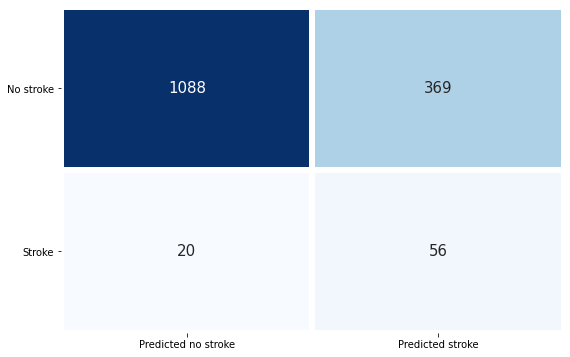

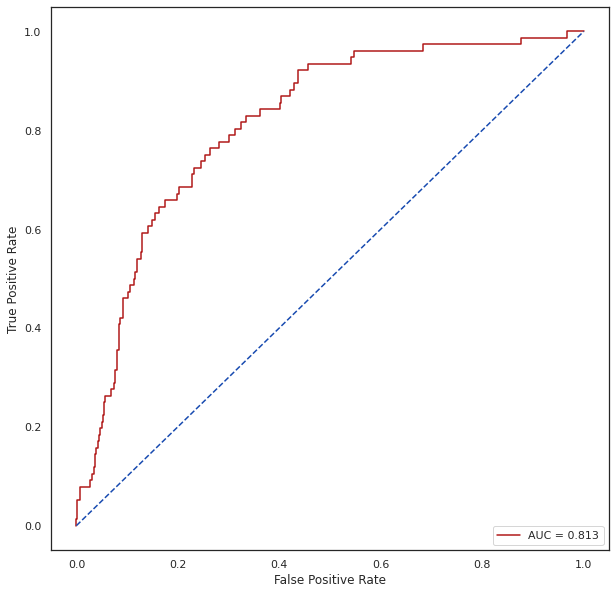

In [ ]:
lg = LogisticRegression(C=0.01,penalty='l2',solver= 'newton-cg', random_state = 17)
lg.fit(X_train_balanced, y_train_balanced)
y_pred = lg.predict(X_test)
y_prob = lg.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 0] = round(accuracy_score(y_test, y_pred), 3)
results.iloc[1, 0] = round(precision_score(y_test, y_pred), 2)
results.iloc[2, 0] = round(recall_score(y_test, y_pred), 2)
results.iloc[3, 0] = round(f1_score(y_test, y_pred), 2)
results.iloc[4, 0] = round(roc_auc_score(y_test, y_prob), 3)
lg_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')

results_cv.iloc[0, 0] = round(cross_val_score(lg, X_train_balanced, y_train_balanced, cv = cv, scoring = 'accuracy').mean(), 3)
results_cv.iloc[1, 0] = round(cross_val_score(lg, X_train_balanced, y_train_balanced, cv = cv, scoring = 'precision').mean(), 2)
results_cv.iloc[2, 0] = round(cross_val_score(lg, X_train_balanced, y_train_balanced, cv = cv, scoring = 'recall').mean(), 2)
results_cv.iloc[3, 0] = round(cross_val_score(lg, X_train_balanced, y_train_balanced, cv = cv, scoring = 'f1').mean(), 2)
results_cv.iloc[4, 0] = round(cross_val_score(lg, X_train_balanced, y_train_balanced, cv = cv, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (9, 6))
sns.heatmap(lg_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (10, 10))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

max_depth = [2, 4, 6, 8]
boosting = ['gbdt', 'rf', 'dart', 'goss']
lgbm_param_grid = {'learning_rate': learning_rate, 
                  'max_depth': max_depth,'boosting': boosting}

lgbm = LGBMClassifier()

grid = GridSearchCV(lgbm, lgbm_param_grid, cv=kfold)

In [ ]:
grid.fit(X_train_balanced, y_train_balanced)
grid.best_params_

{'boosting': 'gbdt', 'learning_rate': 0.3, 'max_depth': 8}

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1457
           1       0.10      0.11      0.10        76

    accuracy                           0.91      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.91      0.91      0.91      1533

ROC AUC score: 0.764


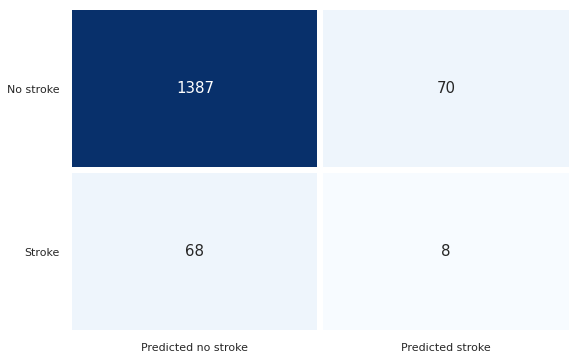

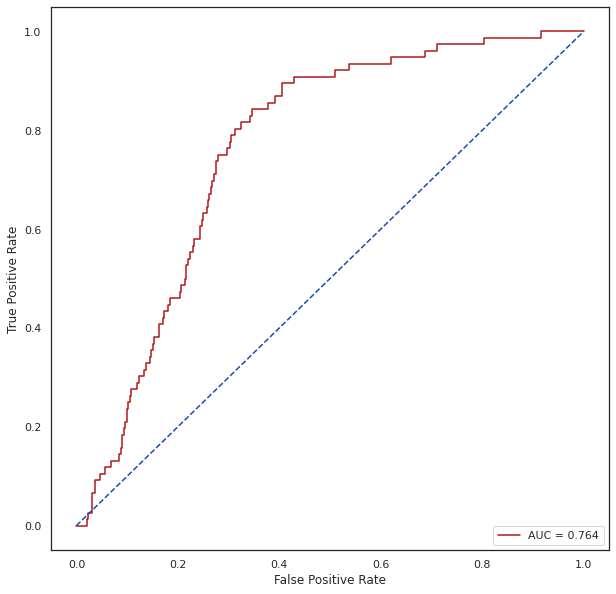

In [ ]:
lgbm = LGBMClassifier(random_state = 17, max_depth = 8, num_leaves = 50, objective= 'binary', boosting_type= 'goss')
lgbm.fit(X_train_balanced, y_train_balanced)
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 1] = round(accuracy_score(y_test, y_pred), 3)
results.iloc[1, 1] = round(precision_score(y_test, y_pred), 2)
results.iloc[2, 1] = round(recall_score(y_test, y_pred), 2)
results.iloc[3, 1] = round(f1_score(y_test, y_pred), 2)
results.iloc[4, 1] = round(roc_auc_score(y_test, y_prob), 3)
lgbm_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')

results_cv.iloc[0, 1] = round(cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv = cv, scoring = 'accuracy').mean(), 3)
results_cv.iloc[1, 1] = round(cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv = cv, scoring = 'precision').mean(), 2)
results_cv.iloc[2, 1] = round(cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv = cv, scoring = 'recall').mean(), 2)
results_cv.iloc[3, 1] = round(cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv = cv, scoring = 'f1').mean(), 2)
results_cv.iloc[4, 1] = round(cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv = cv, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (9, 6))
sns.heatmap(lgbm_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (10, 10))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1457
           1       0.13      0.70      0.22        76

    accuracy                           0.75      1533
   macro avg       0.55      0.73      0.53      1533
weighted avg       0.94      0.75      0.82      1533

ROC AUC score: 0.789


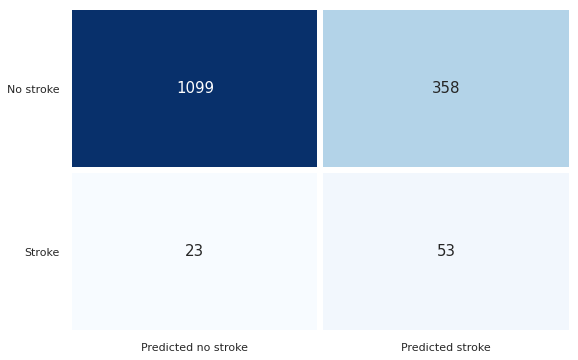

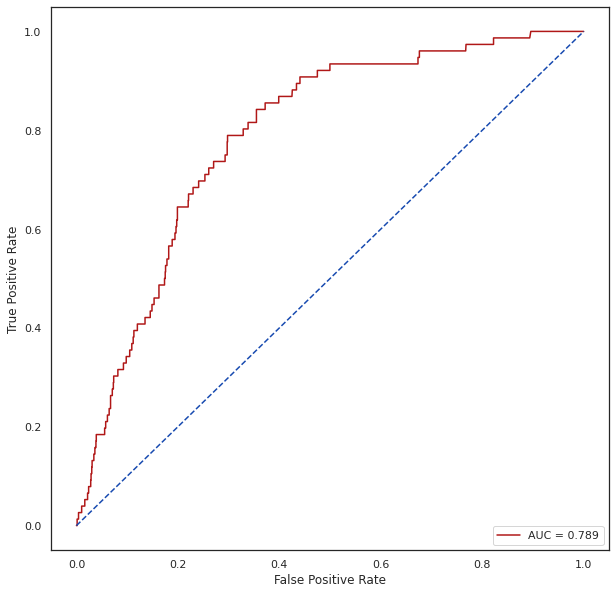

In [ ]:
rf = RandomForestClassifier(random_state = 17, max_depth = 5)
rf.fit(X_train_balanced, y_train_balanced)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 2] = round(accuracy_score(y_test, y_pred), 3)
results.iloc[1, 2] = round(precision_score(y_test, y_pred), 2)
results.iloc[2, 2] = round(recall_score(y_test, y_pred), 2)
results.iloc[3, 2] = round(f1_score(y_test, y_pred), 2)
results.iloc[4, 2] = round(roc_auc_score(y_test, y_prob), 3)
rf_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')

results_cv.iloc[0, 2] = round(cross_val_score(rf, X_train_balanced, y_train_balanced, cv = cv, scoring = 'accuracy').mean(), 3)
results_cv.iloc[1, 2] = round(cross_val_score(rf, X_train_balanced, y_train_balanced, cv = cv, scoring = 'precision').mean(), 2)
results_cv.iloc[2, 2] = round(cross_val_score(rf, X_train_balanced, y_train_balanced, cv = cv, scoring = 'recall').mean(), 2)
results_cv.iloc[3, 2] = round(cross_val_score(rf, X_train_balanced, y_train_balanced, cv = cv, scoring = 'f1').mean(), 2)
results_cv.iloc[4, 2] = round(cross_val_score(rf, X_train_balanced, y_train_balanced, cv = cv, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (9, 6))
sns.heatmap(rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (10, 10))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

max_depth = [2, 4, 6, 8]
xgb_param_grid = {'learning_rate': learning_rate, 
                  'max_depth': max_depth}

xgb = XGBClassifier()

grid = GridSearchCV(xgb, xgb_param_grid, cv=kfold)

In [ ]:
grid.fit(X_train_balanced, y_train_balanced)
grid.best_params_

{'learning_rate': 0.3, 'max_depth': 8}

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1457
           1       0.11      0.07      0.08        76

    accuracy                           0.93      1533
   macro avg       0.53      0.52      0.52      1533
weighted avg       0.91      0.93      0.92      1533

ROC AUC score: 0.766


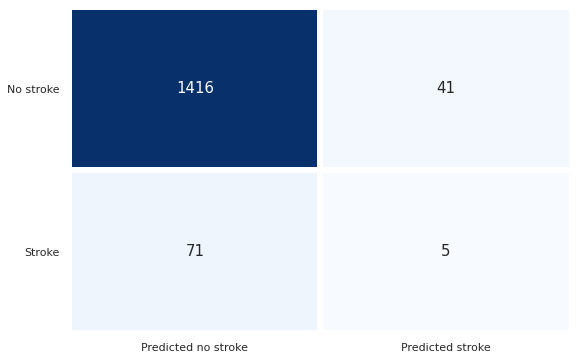

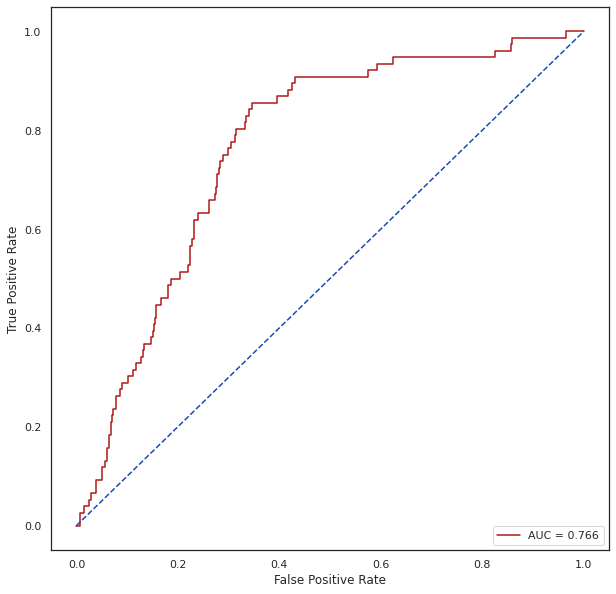

[0.20552178 0.23560527 0.05151603 0.07972188 0.19356485 0.05429556
 0.04726559 0.13250905]


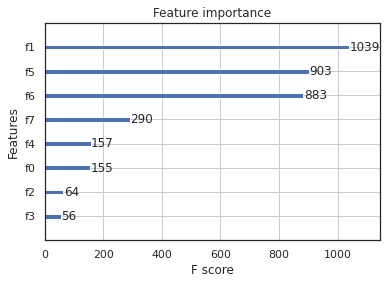

In [ ]:
from xgboost import plot_importance
xgb = XGBClassifier(random_state = 17, learning_rate= 0.3, max_depth = 8, objective = 'binary:logistic', eval_metric = 'logloss', early_stopping_rounds=10, verbose=True)
xgb.fit(X_train_balanced, y_train_balanced)
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 3] = round(accuracy_score(y_test, y_pred), 3)
results.iloc[1, 3] = round(precision_score(y_test, y_pred), 2)
results.iloc[2, 3] = round(recall_score(y_test, y_pred), 2)
results.iloc[3, 3] = round(f1_score(y_test, y_pred), 2)
results.iloc[4, 3] = round(roc_auc_score(y_test, y_prob), 3)
xgb_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')

results_cv.iloc[0, 3] = round(cross_val_score(xgb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'accuracy').mean(), 3)
results_cv.iloc[1, 3] = round(cross_val_score(xgb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'precision').mean(), 2)
results_cv.iloc[2, 3] = round(cross_val_score(xgb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'recall').mean(), 2)
results_cv.iloc[3, 3] = round(cross_val_score(xgb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'f1').mean(), 2)
results_cv.iloc[4, 3] = round(cross_val_score(xgb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (9, 6))
sns.heatmap(xgb_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (10, 10))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(xgb.feature_importances_)
plot_importance(xgb)
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.81      0.89      1457
           1       0.13      0.55      0.21        76

    accuracy                           0.80      1533
   macro avg       0.55      0.68      0.55      1533
weighted avg       0.93      0.80      0.85      1533

ROC AUC score: 0.784


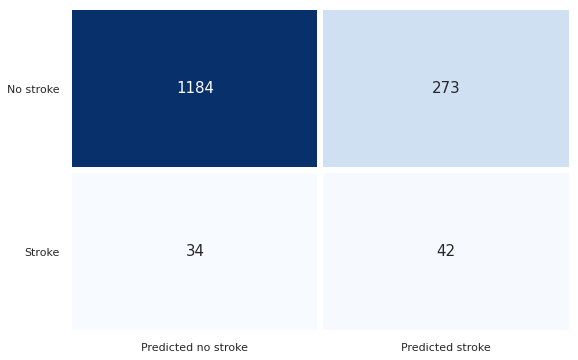

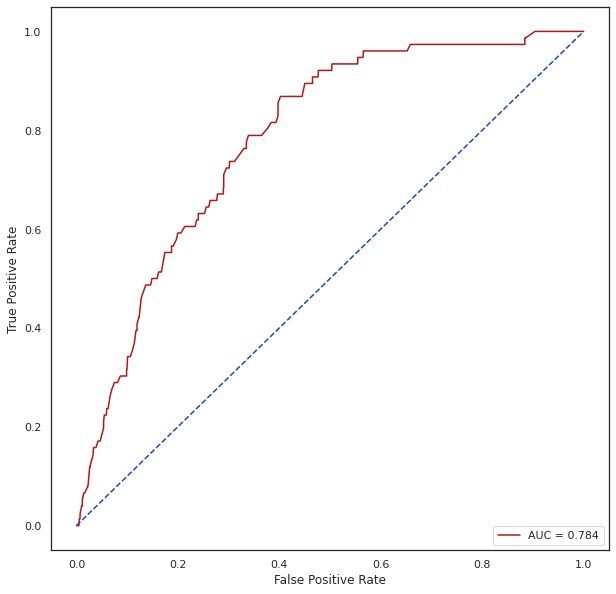

In [ ]:
adb = AdaBoostClassifier(random_state = 17)
adb.fit(X_train_balanced, y_train_balanced)
y_pred = adb.predict(X_test)
y_prob = adb.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 4] = round(accuracy_score(y_test, y_pred), 3)
results.iloc[1, 4] = round(precision_score(y_test, y_pred), 2)
results.iloc[2, 4] = round(recall_score(y_test, y_pred), 2)
results.iloc[3, 4] = round(f1_score(y_test, y_pred), 2)
results.iloc[4, 4] = round(roc_auc_score(y_test, y_prob), 3)
adb_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')

results_cv.iloc[0, 4] = round(cross_val_score(adb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'accuracy').mean(), 3)
results_cv.iloc[1, 4] = round(cross_val_score(adb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'precision').mean(), 2)
results_cv.iloc[2, 4] = round(cross_val_score(adb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'recall').mean(), 2)
results_cv.iloc[3, 4] = round(cross_val_score(adb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'f1').mean(), 2)
results_cv.iloc[4, 4] = round(cross_val_score(adb, X_train_balanced, y_train_balanced, cv = cv, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (9, 6))
sns.heatmap(adb_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (10, 10))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1457
           1       0.10      0.14      0.12        76

    accuracy                           0.89      1533
   macro avg       0.53      0.54      0.53      1533
weighted avg       0.91      0.89      0.90      1533

ROC AUC score: 0.539


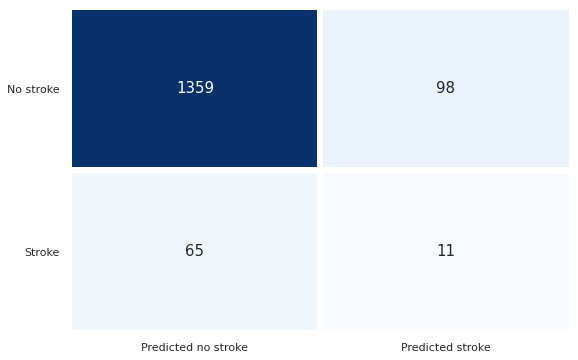

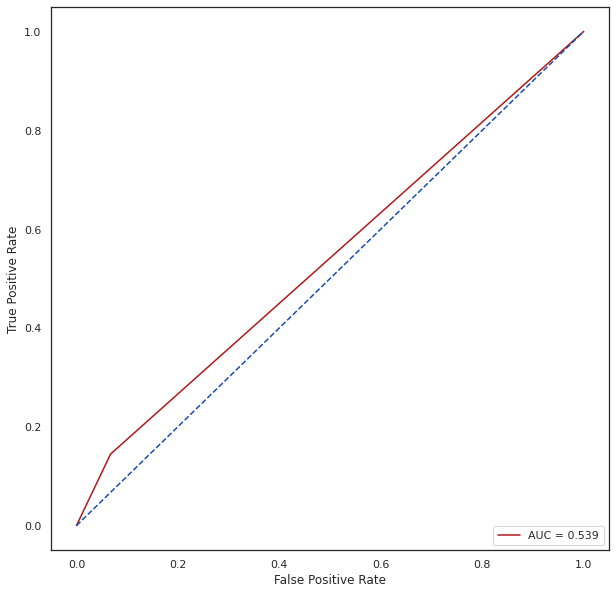

In [ ]:
dtr = DecisionTreeClassifier(random_state = 17)
dtr.fit(X_train_balanced, y_train_balanced)
y_pred = dtr.predict(X_test)
y_prob = dtr.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 5] = round(accuracy_score(y_test, y_pred), 3)
results.iloc[1, 5] = round(precision_score(y_test, y_pred), 2)
results.iloc[2, 5] = round(recall_score(y_test, y_pred), 2)
results.iloc[3, 5] = round(f1_score(y_test, y_pred), 2)
results.iloc[4, 5] = round(roc_auc_score(y_test, y_prob), 3)
dtr_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')

results_cv.iloc[0, 5] = round(cross_val_score(dtr, X_train_balanced, y_train_balanced, cv = cv, scoring = 'accuracy').mean(), 3)
results_cv.iloc[1, 5] = round(cross_val_score(dtr, X_train_balanced, y_train_balanced, cv = cv, scoring = 'precision').mean(), 2)
results_cv.iloc[2, 5] = round(cross_val_score(dtr, X_train_balanced, y_train_balanced, cv = cv, scoring = 'recall').mean(), 2)
results_cv.iloc[3, 5] = round(cross_val_score(dtr, X_train_balanced, y_train_balanced, cv = cv, scoring = 'f1').mean(), 2)
results_cv.iloc[4, 5] = round(cross_val_score(dtr, X_train_balanced, y_train_balanced, cv = cv, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (9, 6))
sns.heatmap(dtr_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (10, 10))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

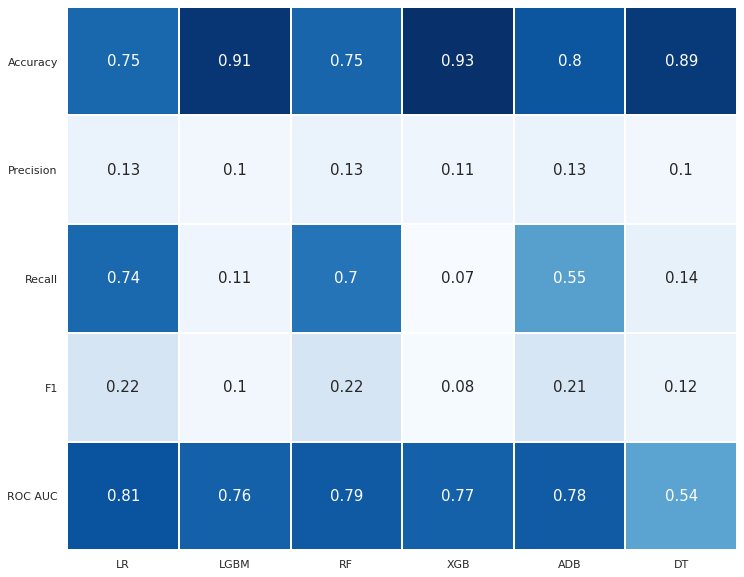

In [ ]:
plt.figure(figsize = (12, 10))
sns.heatmap(results[results.columns.to_list()].astype(float), cmap = 'Blues', annot = True, linewidths = 1, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])
sns.set(font_scale = 1.5)
plt.yticks(rotation = 0)
plt.show()

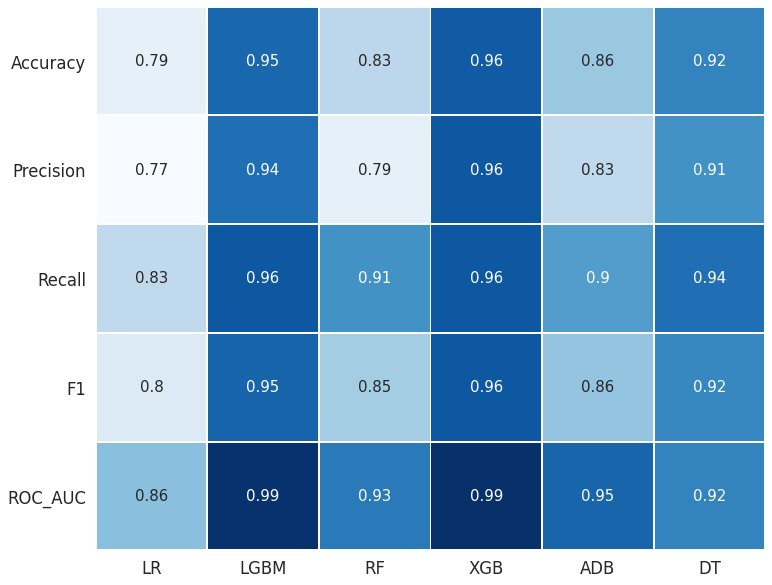

In [ ]:
plt.figure(figsize = (12, 10))
sns.heatmap(results_cv[results_cv.columns.to_list()].astype(float), cmap = 'Blues', annot = True, linewidths = 1, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])
sns.set(font_scale = 1.5)
plt.yticks(rotation = 0)
plt.show()